### Setup and imports

In [45]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### 1. Load Cleaned Data from Week 2

In [46]:
# Load the cleaned DataFrame from Week 2 EDA
df = pd.read_csv('nhanes_clean.csv')

# Quick sanity check
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (4015, 16)

First few rows:


,age,gender,ethnicity,education,marital_status,poverty_ratio,bmi,height_cm,weight_kg,systolic_bp,diastolic_bp,map_pressure,pulse_pressure,bmi_category,hypertension,age_group
0,75,Female,Non-Hispanic Black,Some college,Widowed,0.41,38.9,151.1,88.8,120,66,84.000000,54,Obese,0,60-74
1,56,Male,Non-Hispanic Asian,College graduate+,Married,5.00,21.3,170.6,62.1,108,68,81.333333,40,Normal,0,45-59
2,67,Male,Non-Hispanic White,High school/GED,Divorced,2.65,23.5,178.6,74.9,104,70,81.333333,34,Normal,0,60-74
3,71,Male,Other/Multi-Racial,High school/GED,Married,1.56,22.5,170.6,65.6,112,60,77.333333,52,Normal,0,60-74
4,61,Male,Non-Hispanic Asian,College graduate+,Married,5.00,30.7,159.2,77.7,120,72,88.000000,48,Obese,0,60-74


In [47]:
# Check columns available
print("Available columns:")
print(df.columns.tolist())

Available columns:
['age', 'gender', 'ethnicity', 'education', 'marital_status', 'poverty_ratio', 'bmi', 'height_cm', 'weight_kg', 'systolic_bp', 'diastolic_bp', 'map_pressure', 'pulse_pressure', 'bmi_category', 'hypertension', 'age_group']


In [48]:
# Verify hypertension flag exists and check distribution
print("\nHypertension distribution:")
print(df['hypertension'].value_counts())
print(f"\nHypertension prevalence: {df['hypertension'].mean():.2%}")


Hypertension distribution:
hypertension
0    3028
1     987
Name: count, dtype: int64

Hypertension prevalence: 24.58%


### 2. Feature Selection - Drop Redundant Features

#### Check Weight vs BMI Correlation

Weight vs BMI correlation:
           weight_kg       bmi
weight_kg   1.000000  0.892826
bmi         0.892826  1.000000


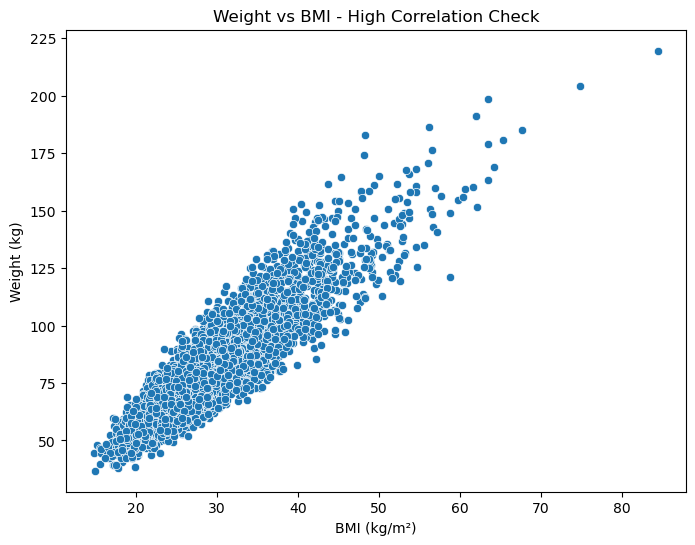

In [49]:
# Correlation between weight and BMI
correlation = df[['weight_kg', 'bmi']].corr()
print("Weight vs BMI correlation:")
print(correlation)

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='bmi', y='weight_kg')
plt.title('Weight vs BMI - High Correlation Check')
plt.xlabel('BMI (kg/m²)')
plt.ylabel('Weight (kg)')
plt.show()

**Decision rationale:**
- High correlation between weight and BMI (expected r > 0.9)
- BMI is derived from weight and height, making weight redundant
- BMI is more clinically interpretable (standardized measure)
- **Action:** Drop weight column

### Drop Redundant Features

In [50]:
# List features to drop and document why
features_to_drop = [
    'weight_kg',           # Redundant with BMI (high correlation, BMI more interpretable)
    'systolic_bp',      # Replaced by MAP and hypertension flag
    'diastolic_bp',     # Replaced by MAP and pulse_pressure
    # Add any other redundant features based on your EDA
]

# Check which columns actually exist before dropping
existing_drops = [col for col in features_to_drop if col in df.columns]
print(f"Dropping columns: {existing_drops}")

# Drop features
df_model = df.drop(columns=existing_drops)

print(f"\nNew shape after dropping redundant features: {df_model.shape}")

Dropping columns: ['weight_kg', 'systolic_bp', 'diastolic_bp']

New shape after dropping redundant features: (4015, 13)


In [51]:
# Verify remaining columns
print("Remaining features:")
print(df_model.columns.tolist())

Remaining features:
['age', 'gender', 'ethnicity', 'education', 'marital_status', 'poverty_ratio', 'bmi', 'height_cm', 'map_pressure', 'pulse_pressure', 'bmi_category', 'hypertension', 'age_group']


### 3. Separate Features and Target 
##### seperating into 2 sets for training and testing

In [52]:
# Define target variable
y = df_model['hypertension']

# Define features (everything except target)
X = df_model.drop(columns=['hypertension'])

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts(normalize=True))

Features shape: (4015, 12)
Target shape: (4015,)

Target distribution:
hypertension
0    0.754172
1    0.245828
Name: proportion, dtype: float64


### 4. Encode Categorical Variables

#### Identify Categorical vs Numerical Features

In [53]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

# Identify numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nNumerical columns: {numerical_cols}")

Categorical columns: ['gender', 'ethnicity', 'education', 'marital_status', 'bmi_category', 'age_group']

Numerical columns: ['age', 'poverty_ratio', 'bmi', 'height_cm', 'map_pressure', 'pulse_pressure']


#### One-Hot Encoding for Nominal Categoricals

In [64]:
# One-hot encode categorical variables
# Use drop_first=True to avoid multicollinearity (dummy variable trap)

X_encoded = pd.get_dummies(
    X, 
    columns=categorical_cols,  # Specify which columns to encode
    drop_first=True,           # Drop first category as reference
    dtype=int                  # Use integer type (0/1) instead of boolean
)

print(f"\nShape after encoding: {X_encoded.shape}")
print(f"New columns created: {X_encoded.shape[1] - X.shape[1]}")


Shape after encoding: (4015, 29)
New columns created: 17


**Decision rationale:**
- One-hot encoding for nominal categories (ethnicity, education, marital status)
- `drop_first=True` prevents multicollinearity by creating n-1 dummy variables
- Alternative would be label encoding, but that assumes ordinal relationship (not appropriate for nominal data)

In [65]:
# View the encoded columns
print("\nEncoded feature names:")
print(X_encoded.columns.tolist())


Encoded feature names:
['age', 'poverty_ratio', 'bmi', 'height_cm', 'map_pressure', 'pulse_pressure', 'gender_Male', 'ethnicity_Non-Hispanic Asian', 'ethnicity_Non-Hispanic Black', 'ethnicity_Non-Hispanic White', 'ethnicity_Other Hispanic', 'ethnicity_Other/Multi-Racial', 'education_College graduate+', 'education_High school/GED', 'education_Less than 9th grade', 'education_Some college', 'marital_status_Living with partner', 'marital_status_Married', 'marital_status_Never married', 'marital_status_Separated', 'marital_status_Widowed', 'bmi_category_Obese', 'bmi_category_Overweight', 'bmi_category_Severely Obese', 'bmi_category_Underweight', 'age_group_30-44', 'age_group_45-59', 'age_group_60-74', 'age_group_75+']


### 5. Train/Test Split (BEFORE Scaling!)

#### Critical: Split BEFORE scaling to prevent data leakage

In [66]:
# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    test_size=0.2,           # 80/20 split
    random_state=42,         # Reproducibility
    stratify=y               # Preserve class distribution
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X_encoded):.1%})")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X_encoded):.1%})")

Training set size: 3212 (80.0%)
Test set size: 803 (20.0%)


**Decision rationale:**
- 80/20 split is standard for moderately sized datasets
- Stratification ensures hypertension prevalence is equal in train/test
- random_state=42 for reproducibility
- Split BEFORE scaling to prevent data leakage (test data must not influence scaler)


#### Verify Class Balance

In [67]:
# Check class distribution in train vs test
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

# Should be very similar due to stratification


Class distribution in training set:
hypertension
0    0.754047
1    0.245953
Name: proportion, dtype: float64

Class distribution in test set:
hypertension
0    0.75467
1    0.24533
Name: proportion, dtype: float64


### 6. Normalize/Standardize Numerical Features

#### Identify Numerical Columns in Encoded Data

In [68]:
# Identify which columns need scaling (numerical features only)
# Exclude one-hot encoded columns (already 0/1)

# Get column names that are NOT one-hot encoded (i.e., original numerical features)
numerical_features = [col for col in X_encoded.columns if col in numerical_cols]

print(f"Numerical features to scale: {numerical_features}")

Numerical features to scale: ['age', 'poverty_ratio', 'bmi', 'height_cm', 'map_pressure', 'pulse_pressure']


#### Fit Scaler on Training Data Only

In [69]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on TRAINING data only
scaler.fit(X_train[numerical_features])

# Transform both train and test using the SAME scaler
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("Scaling complete!")

Scaling complete!


**Decision rationale:**
- StandardScaler (z-score normalization): mean=0, std=1
- Alternative is MinMaxScaler (0-1 range), but StandardScaler is better for:
  - Features with outliers (less sensitive)
  - Algorithms assuming normal distribution (logistic regression)
- Fit on training data ONLY to prevent data leakage
- One-hot encoded columns don't need scaling (already 0/1)

#### Verify Scaling

In [70]:
# Check mean and std of scaled training data (should be ~0 and ~1)
print("\nScaled training data statistics:")
print(X_train_scaled[numerical_features].describe())


Scaled training data statistics:
                age  poverty_ratio           bmi     height_cm  map_pressure  \
count  3.212000e+03   3.212000e+03  3.212000e+03  3.212000e+03  3.212000e+03   
mean   7.410704e-17  -3.871263e-17  2.743067e-16  2.616974e-15  1.245441e-15   
std    1.000156e+00   1.000156e+00  1.000156e+00  1.000156e+00  1.000156e+00   
min   -1.748198e+00  -1.586776e+00 -2.043564e+00 -2.771282e+00 -4.309918e+00   
25%   -8.977519e-01  -8.384890e-01 -6.881473e-01 -7.526218e-01 -6.383589e-01   
50%    6.608696e-02  -2.648027e-01 -1.678862e-01 -3.956264e-02 -6.139950e-02   
75%    8.031402e-01   9.573987e-01  5.166678e-01  7.237120e-01  5.680107e-01   
max    1.653586e+00   1.531085e+00  6.157393e+00  2.933191e+00  5.288587e+00   

       pulse_pressure  
count    3.212000e+03  
mean     8.848602e-17  
std      1.000156e+00  
min     -1.870048e+00  
25%     -6.409306e-01  
50%     -2.312248e-01  
75%      3.833338e-01  
max      5.811935e+00  


### 7. Final Dataset Summary

In [71]:
print("=" * 60)
print("FINAL PREPROCESSED DATASETS SUMMARY")
print("=" * 60)

print(f"\nTraining set:")
print(f"  Features: {X_train_scaled.shape}")
print(f"  Target: {y_train.shape}")
print(f"  Hypertension prevalence: {y_train.mean():.2%}")

print(f"\nTest set:")
print(f"  Features: {X_test_scaled.shape}")
print(f"  Target: {y_test.shape}")
print(f"  Hypertension prevalence: {y_test.mean():.2%}")

print(f"\nTotal features: {X_train_scaled.shape[1]}")
print(f"  - Numerical (scaled): {len(numerical_features)}")
print(f"  - Categorical (one-hot encoded): {X_train_scaled.shape[1] - len(numerical_features)}")

FINAL PREPROCESSED DATASETS SUMMARY

Training set:
  Features: (3212, 29)
  Target: (3212,)
  Hypertension prevalence: 24.60%

Test set:
  Features: (803, 29)
  Target: (803,)
  Hypertension prevalence: 24.53%

Total features: 29
  - Numerical (scaled): 6
  - Categorical (one-hot encoded): 23


### 8. Save Preprocessed Data

In [72]:
# Save training set
X_train_scaled.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

# Save test set
X_test_scaled.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("\nPreprocessed datasets saved:")
print("  - X_train.csv")
print("  - y_train.csv")
print("  - X_test.csv")
print("  - y_test.csv")


Preprocessed datasets saved:
  - X_train.csv
  - y_train.csv
  - X_test.csv
  - y_test.csv


In [73]:
# Optional: Save the scaler for future use
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("\nScaler saved as scaler.pkl")


Scaler saved as scaler.pkl
